# Using LSTMs with the subwords dataset


In this colab, you'll compare the results of using a model with an Embedding layer and then adding bidirectional LSTM layers.

You'll work with the dataset of subwords for the combined Yelp and Amazon reviews.

You'll use your models to predict the sentiment of new reviews.

In [13]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the dataset

Start by getting the dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).


In [14]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2024-08-03 14:45:00--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.251.175.138, 142.251.175.139, 142.251.175.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.175.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2024-08-03 14:45:00--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.001s  

2024-08-03 14:45:02 (9

In [15]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [16]:
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




#Create a subwords dataset

We will use the Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality.

SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

We'll create a subword vocab_size of only the 1,000 most common subwords, as well as cutting off each subword to be at most 5 characters.

Check out the related documentation for the the subword text encoder [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus).

In [17]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

print("Vocab size is :", tokenizer.vocab_size)

Vocab size is : 999


In [18]:
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [19]:
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Replace sentence data with encoded subwords

Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to `text_to_sequences` with the `Tokenizer` we used in earlier exercises.

In [20]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [21]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [22]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Create the model using an Embedding

In [23]:
embedding_dim = 16

model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # GlobalMaxPooling1D layer to reduce dimensionality
    tf.keras.layers.GlobalMaxPooling1D(),

    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.5),

    # Dense layer with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),

    # Batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    # Additional Dense layer
    tf.keras.layers.Dense(32, activation='relu'),

    # Dropout layer
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [24]:
num_epochs = 30

history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5116 - loss: 0.7070 - val_accuracy: 0.4110 - val_loss: 0.6951
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5421 - loss: 0.6903 - val_accuracy: 0.4110 - val_loss: 0.6948
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6313 - loss: 0.6399 - val_accuracy: 0.6717 - val_loss: 0.6804
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7830 - loss: 0.4849 - val_accuracy: 0.7519 - val_loss: 0.6332
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8798 - loss: 0.3278 - val_accuracy: 0.7293 - val_loss: 0.6108
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8716 - loss: 0.3043 - val_accuracy: 0.7519 - val_loss: 0.5710
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9231 - loss: 0.2236 - val_accuracy: 0.7619 - val_loss: 0.5126
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9221 - loss: 0.2217 - val_accuracy: 0.7293 - 

# Plot the accuracy and loss

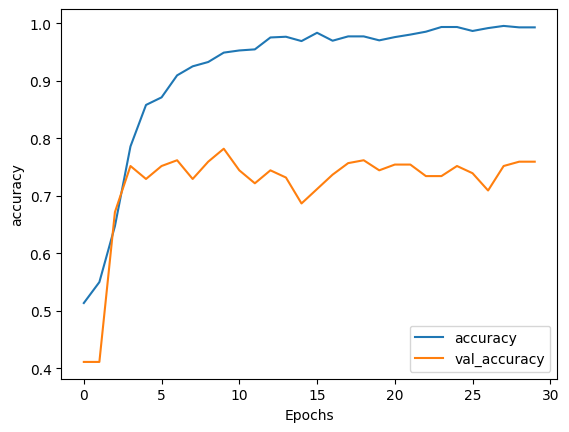

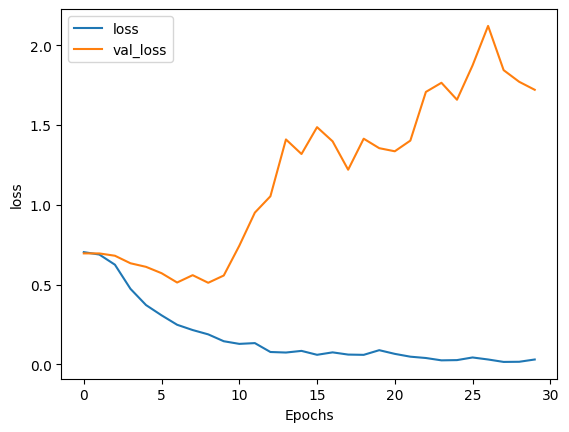

In [25]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Define a function to predict the sentiment of reviews

We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.

In [26]:
# Define a function to take a series of reviews

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post'
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):

    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [27]:
# Use the model to predict some reviews
fake_reviews = [
    'I love this phone',
    'I hate spaghetti',
    'Everything was cold',
    'Everything was hot exactly as I wanted',
    'Everything was green',
    'The host seated us immediately',
    'They gave us free chocolate cake',
    'Not sure about the wilted flowers on the table',
    'Only works when I stand on tippy toes',
    'Does not work when I stand on my head',
    'The service was incredibly slow',
    'The view from the room was breathtaking',
    'The coffee was too bitter for my taste',
    'The restaurant had a cozy atmosphere',
    'The movie was too long and boring',
    'The staff were friendly and helpful',
    'The dessert was too sweet and rich',
    'The room was clean but a bit cramped',
    'The Wi-Fi connection was unreliable',
    'The gym facilities were excellent',
    'The book had an unexpected twist ending',
    'The event was well-organized and enjoyable',
    'The jacket was comfortable but a bit tight',
    'The price was too high for the quality',
    'The app crashed frequently during use',
    'The concert was amazing and lively',
    'The directions were confusing and unclear',
    'The packaging was eco-friendly and attractive',
    'The product arrived ahead of schedule',
    'The noise level was higher than expected',
    'The ambiance of the cafe was relaxing',
    'The hotel room lacked proper ventilation',
    'The customer service was outstanding',
    'The meal portions were too small',
    'The movie soundtrack was fantastic',
    'The bed was incredibly comfortable',
    'The website interface was user-friendly',
    'The hiking trail was beautiful and challenging',
    'The delivery was prompt and efficient',
    'The book was well-written and engaging',
    'The sauce was too salty for my taste',
    'The lighting in the restaurant was too dim',
    'The app is intuitive and easy to navigate',
    'The venue was difficult to find',
    'The salad was fresh and well-seasoned',
    'The parking situation was inconvenient',
    'The product instructions were unclear',
    'The staff went above and beyond',
    'The music selection was varied and enjoyable',
    'The class was informative and interactive',
    'The paint color was not as described'
]


predict_review(model, fake_reviews)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99999213]


[  4  96 266 135 683 207 276 848   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I hate spaghetti
[6.36093e-05]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[1.0007106e-05]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0

# Define a function to train and show the results of models with different layers

In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.

In [28]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs,
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# Add a bidirectional LSTM

Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.

In [29]:
model_bidi_lstm = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # GlobalMaxPooling1D layer to reduce dimensionality
    tf.keras.layers.GlobalMaxPooling1D(),

    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.5),

    # Dense layer with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),

    # Batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    # Additional Dense layer
    tf.keras.layers.Dense(32, activation='relu'),

    # Dropout layer
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_bidi_lstm.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Model summary
model_bidi_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5268 - loss: 0.6981 - val_accuracy: 0.4110 - val_loss: 0.7020
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5608 - loss: 0.6823 - val_accuracy: 0.4110 - val_loss: 0.7044
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7161 - loss: 0.5838 - val_accuracy: 0.4236 - val_loss: 0.6933
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8587 - loss: 0.3755 - val_accuracy: 0.6115 - val_loss: 0.6429
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8697 - loss: 0.3312 - val_accuracy: 0.7368 - val_loss: 0.5888
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9029 - loss: 0.2549 - val_accuracy: 0.6291 - val_loss: 0.6394
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9201 - loss: 0.1993 - val_accuracy: 0.7569 - val_loss: 0.5218
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9363 - loss: 0.1767 - val_accuracy: 0.7243 - v

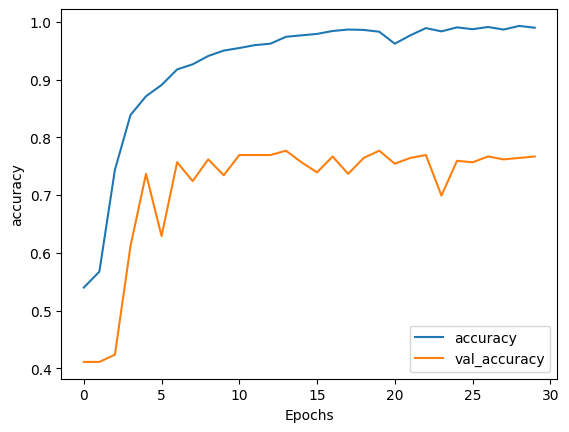

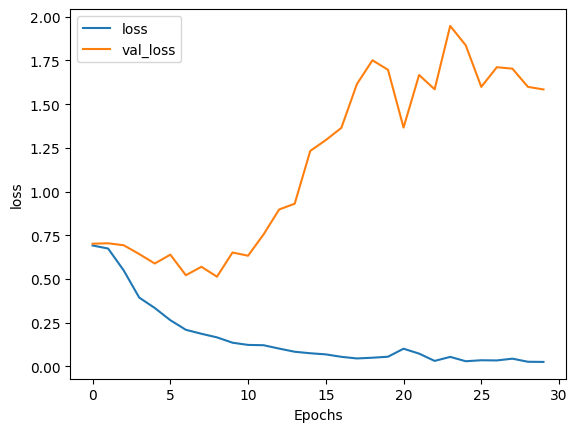

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99995077]


[  4  96 266 135 683 207 276 848   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I hate spaghetti
[0.00336484]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[1.3560293e-05]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.

In [30]:
# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)

# Use multiple bidirectional layers

Now let's see if we get any improvements from adding another Bidirectional LSTM layer to the model.

Notice that the first Bidirectionl LSTM layer returns a sequence.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5217 - loss: 0.6927 - val_accuracy: 0.4110 - val_loss: 0.7028
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5431 - loss: 0.6696 - val_accuracy: 0.6541 - val_loss: 0.6553
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8021 - loss: 0.5272 - val_accuracy: 0.7594 - val_loss: 0.6244
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8830 - loss: 0.4506 - val_accuracy: 0.7594 - val_loss: 0.6313
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8842 - loss: 0.3985 - val_accuracy: 0.7594 - val_loss: 0.6383
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8960 - loss: 0.3184 - val_accuracy: 0.7644 - val_loss: 0.6342
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9205 - loss: 0.2280 - val_accuracy: 0.7594 - val_loss: 0.6761
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9186 - loss: 0.2292 - val_accuracy: 0.7644 - v

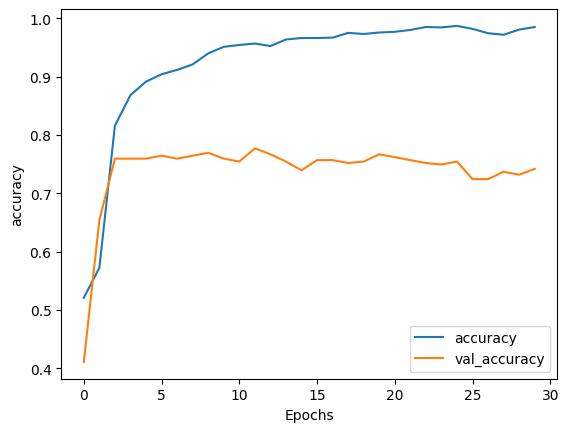

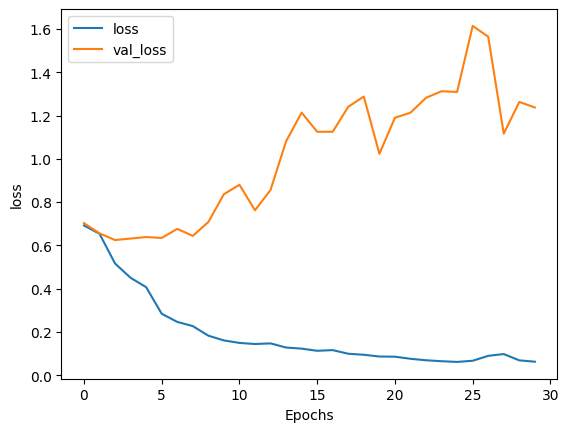

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99993217]


[  4  96 266 135 683 207 276 848   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I hate spaghetti
[0.03791342]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.02707702]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.044

In [31]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Compare predictions for all the models

It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

*   Embeddings and a Global Average Pooling layer
*   Embeddings and a Bidirectional LSTM layer
*   Embeddings and two Bidirectional LSTM layers

The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the  model, such as these two reviews:

*   Bad Quality.
*   Low Quality.

Feel free to add more reviews of your own, or change the reviews. The results will depend on the combination of words in the reviews, and how well they match to reviews in the training set.

How do the different models handle things like "wasn't good" which contains a positive word (good) but is a poor review?


In [32]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [33]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
lovely
[0.99999976]


dreadful
[0.00014762]


stay away
[0.9804083]


everything was hot exactly as I wanted
[0.9998864]


everything was not exactly as I wanted
[0.96245736]


they gave us free chocolate cake
[0.99998915]


I've never eaten anything so spicy in my life, my throat burned for hours
[1.5982067e-05]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.84253377]


we left there very full for a low price so I'd say you just can't go wrong at this place
[4.7504418e-05]


that place does not have quality meals and it isn't a good place to go for dinner
[0.00035369]




In [34]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
lovely
[0.99999857]


dreadful
[4.8332964e-05]


stay away
[0.67703736]


everything was hot exactly as I wanted
[0.9997943]


everything was not exactly as I wanted
[0.93160194]


they gave us free chocolate cake
[0.97968674]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.00328549]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.6872014]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.0957957]


that place does not have quality meals and it isn't a good place to go for dinner
[0.02105313]




In [35]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
lovely
[0.99994123]


dreadful
[0.03900621]


stay away
[0.6948003]


everything was hot exactly as I wanted
[0.9956632]


everything was not exactly as I wanted
[0.06781624]


they gave us free chocolate cake
[0.99989164]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02420788]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01237706]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.02675619]


that place does not have quality meals and it isn't a good place to go for dinner
[0.02789856]


